<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Применение-скользящего-среднего-и-стационарного-ряда" data-toc-modified-id="Применение-скользящего-среднего-и-стационарного-ряда-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Применение скользящего среднего и стационарного ряда</a></span></li><li><span><a href="#Применение-тренда-и-сезонности" data-toc-modified-id="Применение-тренда-и-сезонности-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Применение тренда и сезонности</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия-LinearRegression" data-toc-modified-id="Линейная-регрессия-LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия LinearRegression</a></span></li><li><span><a href="#Модель-RandomForestRegressor" data-toc-modified-id="Модель-RandomForestRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель RandomForestRegressor</a></span></li><li><span><a href="#Модель-CatBoostRegressor" data-toc-modified-id="Модель-CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Модель-LinearRegression-на-тестевой-выборке" data-toc-modified-id="Модель-LinearRegression-на-тестевой-выборке-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Модель LinearRegression на тестевой выборке</a></span></li><li><span><a href="#Модель-RandomForestRegressor-на-тестевой-выборке" data-toc-modified-id="Модель-RandomForestRegressor-на-тестевой-выборке-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Модель RandomForestRegressor на тестевой выборке</a></span></li><li><span><a href="#Модель-CatBoostRegressor-на-тестевой-выборке" data-toc-modified-id="Модель-CatBoostRegressor-на-тестевой-выборке-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Модель CatBoostRegressor на тестевой выборке</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# Импортируем все необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer
from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor

RND = 12345

In [2]:
# Выведем датафрейм и переведем первый столбец в формат даты и время 
try:
    df = pd.read_csv('D://Data Science//Проекты//Прогнозирование заказов такси//taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])


# Выведем датафрейм 
display(df)
display(df.describe())
df.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
# Отсортируем таблицу индекс таблицы и проверим, расположены ли они в хронологическом порядке
df.sort_index(inplace=True)
print(df.index.is_monotonic)

True


In [4]:
# Создадим функцию, которая выведет количество пропущенных и уникальных значений таблиц
def information(data):
    for i in data.columns:
        print(f'\nУникальные значения {i}:\n', data[i].unique())
    print('\nКоличество пропущенных значений:\n', data.isna().sum())

In [5]:
information(df)


Уникальные значения num_orders:
 [  9  14  28  20  32  21   7   5  17  12  19  25  22   8   6   4  10  13
   2   3   0   1  11  15  16  23  18  33  24  26  30  38  34  42  31  27
  36  29  35  56  37  40  39  45  49  58  68  43  53  44  41  52  46  57
  47  64  61  50  48  55  62  54  71  78 119  99  51  60  87  90  94  82
  80  91  76  66  65  98  81  95  67]

Количество пропущенных значений:
 num_orders    0
dtype: int64


In [6]:
# Ресемплируем данные по одному часу 
df = df.resample('1H').sum() 

**Вывод:** Данные обработанны, отсортированы в хронологическом порядке и ресемплированы, дополнительной предобработки не требуется

## Анализ

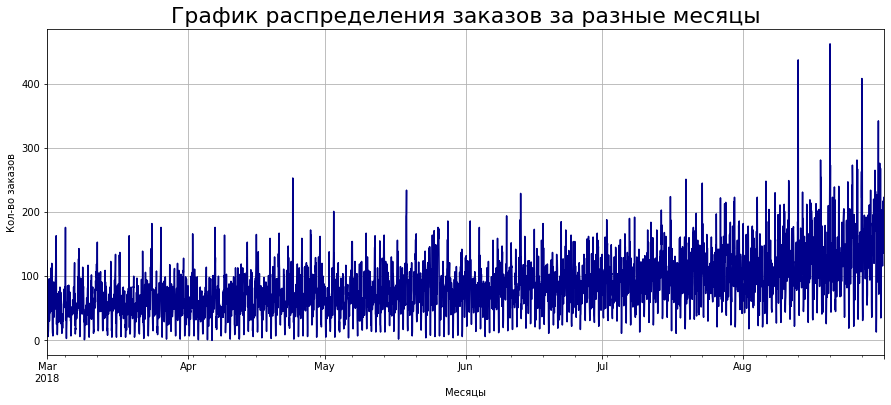

In [7]:
# Построим график для наглядного представления данных 
df['num_orders'].plot(figsize=(15,6), grid=True, color='darkblue');
plt.title('График распределения заказов за разные месяцы', fontsize=22)
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

График не читабелен, укажем временной промежуток за август, для более наглядного представления

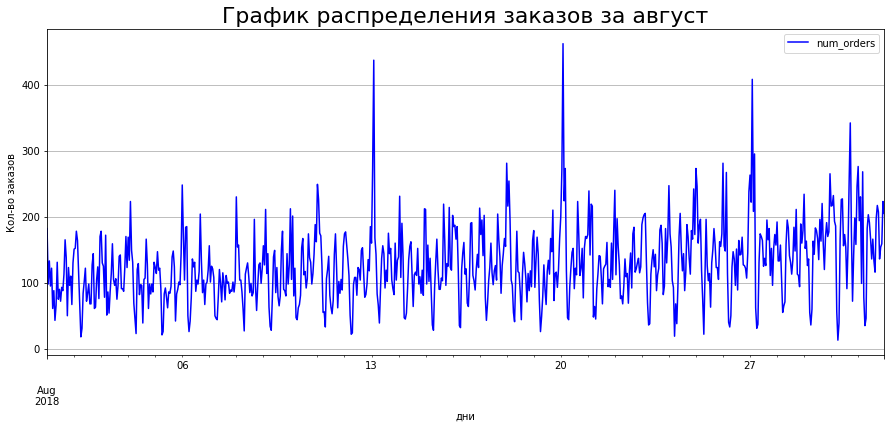

In [8]:
# Выведем данные за один месяц
df['2018-08-01':'2018-08-31'].plot(figsize=(15,6), grid=True, color='blue');
plt.title('График распределения заказов за август', fontsize=22)
plt.xlabel('дни')
plt.ylabel('Кол-во заказов')
plt.show()

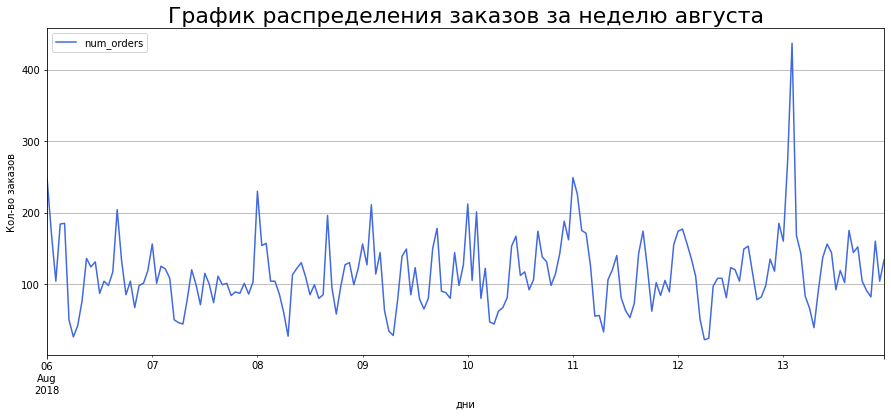

In [9]:
# Выведем график за неделю
df['2018-08-06':'2018-08-13'].plot(figsize=(15,6), grid=True, color='royalblue');
plt.title('График распределения заказов за неделю августа', fontsize=22)
plt.xlabel('дни')
plt.ylabel('Кол-во заказов')
plt.show()

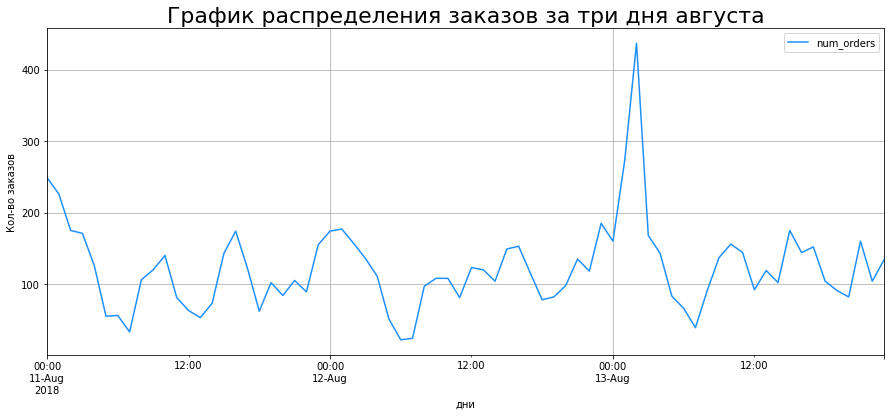

In [10]:
# Выведем график за три дня 
df['2018-08-11':'2018-08-13'].plot(figsize=(15,6), grid=True, color='dodgerblue');
plt.title('График распределения заказов за три дня августа', fontsize=22)
plt.xlabel('дни')
plt.ylabel('Кол-во заказов')
plt.show()

Скачок происходит в понеденьльник после двенадцати часов ночи и ближе к утру снижаются 
Построим графики с скользящим среднем 

### Применение скользящего среднего и стационарного ряда

In [11]:
# Создадим новый датафрейм и сохраним в него основные значений 
df_rs = df

# Добавим столбец скользящего среднего с размером равным 10
df_rs['rolling_mean'] = df_rs.rolling(10).mean()

# добавим столбец стационарного ряда
df_rs['std'] = df_rs['num_orders'].rolling(15).std()


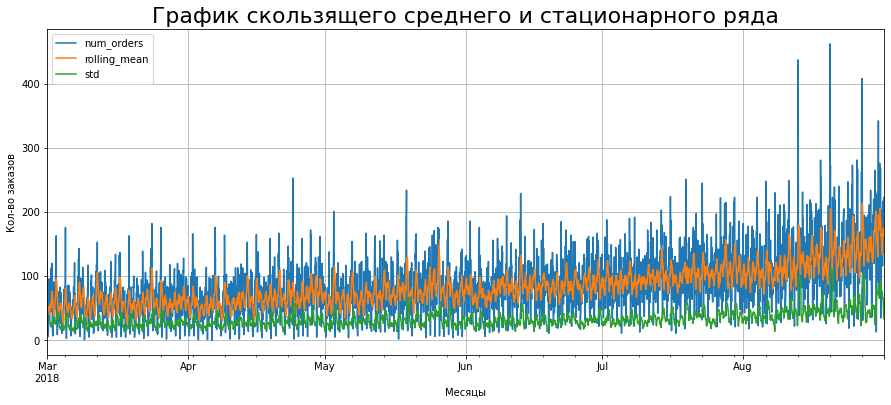

In [12]:
# Построим график
df_rs.plot(figsize=(15,6), grid=True);
plt.title('График скользящего среднего и стационарного ряда', fontsize=22)
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

Среднее и стандартное отклонения изменяются со временем, а значит временной ряд нестационарный.
Проведем декомпозицию для просмотра тренда и сезонности

### Применение тренда и сезонности 

Применим декомпозицию к разным промежуткам времени

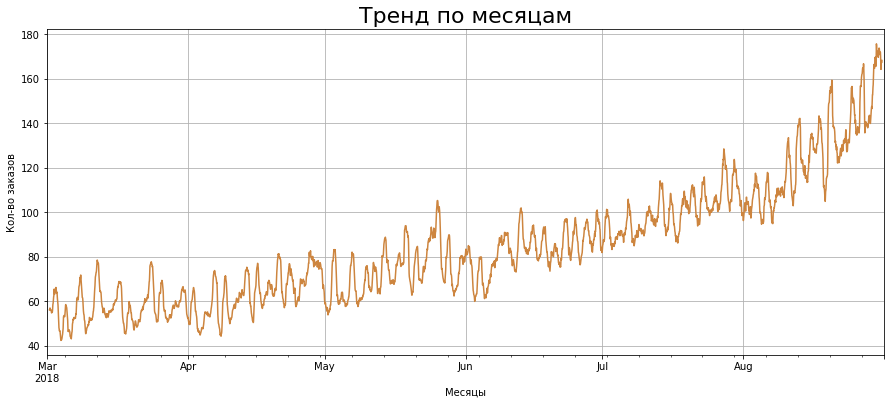

In [13]:
# Применим декомпозицию к разным временным промежуткам
decomposed =  seasonal_decompose(df.num_orders)

decomposed_month = seasonal_decompose(df['2018-08-01':'2018-08-31'].num_orders) 

decomposed_week = seasonal_decompose(df['2018-08-06':'2018-08-13'].num_orders) 


decomposed_day = seasonal_decompose(df['2018-08-11':'2018-08-13'].num_orders)

decomposed.trend.plot(figsize=(15,6), grid=True, color='peru')
plt.title('Тренд по месяцам', fontsize=22)
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()


#decomposed_month.trend.plot(figsize=(15,6), grid=True, color='darkorange')
#plt.title('Тренд за август', fontsize=22)
#plt.xlabel('Месяцы')
#plt.ylabel('Кол-во заказов')
#plt.show()

#decomposed_week.trend.plot(figsize=(15,6), grid=True, color='orange')
#plt.title('Тренд по недели августа', fontsize=22)
#plt.xlabel('Дни')
#plt.ylabel('Кол-во заказов')
#plt.show()

#decomposed_day.trend.plot(figsize=(15,6), grid=True, color='gold')
#plt.title('Тренд по трем дням августа',  fontsize=22)
#plt.xlabel('Дни')
#plt.ylabel('Кол-во заказов')
#plt.show()

Теперь проверим данные на сезонность 

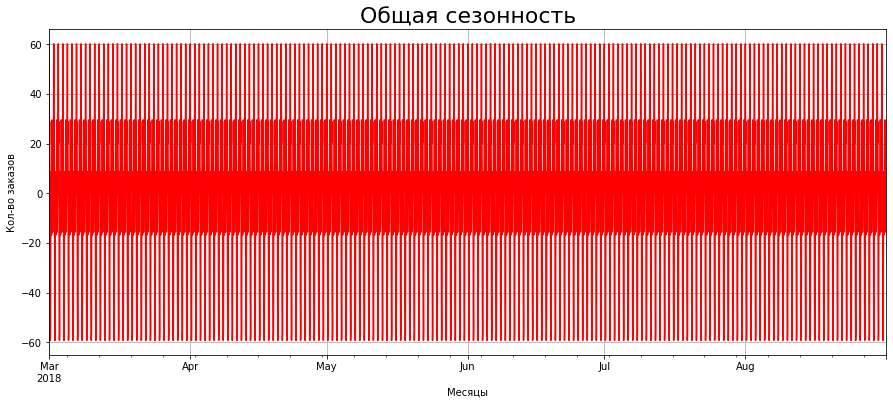

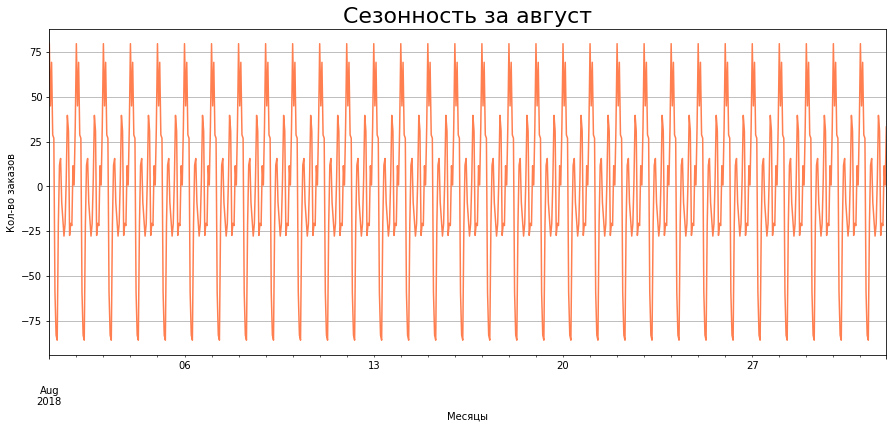

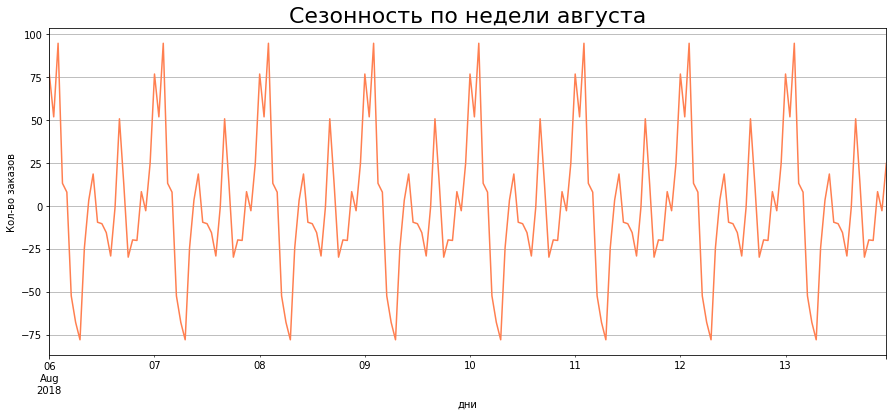

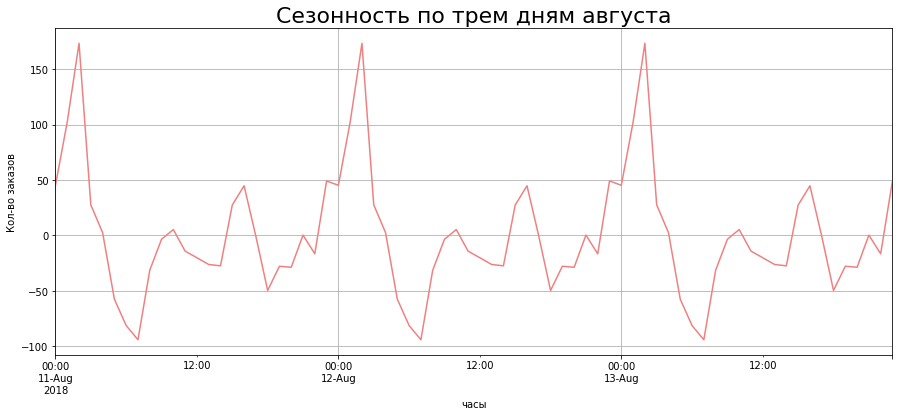

In [14]:
decomposed.seasonal.plot(figsize=(15,6), grid=True, color='red');
plt.title('Общая сезонность', fontsize=22)
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

decomposed_month.seasonal.plot(figsize=(15,6), grid=True, color='coral');
plt.title('Сезонность за август', fontsize=22)
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()


decomposed_week.seasonal.plot(figsize=(15,6), grid=True, color='coral');
plt.title('Сезонность по недели августа', fontsize=22)
plt.xlabel('дни')
plt.ylabel('Кол-во заказов')
plt.show()

decomposed_day.seasonal.plot(figsize=(15,6), grid=True, color='lightcoral');
plt.title('Сезонность по трем дням августа', fontsize=22)
plt.xlabel('часы')
plt.ylabel('Кол-во заказов')
plt.show()

Как видно на графике сезонности по трем дням, возникает явная суточная сезонность, больше всего закозов происходит после полуночи, так как мы рассматриваем данные закозов такси в аэропортах, то в качестве предположений можно сделать теорию о том, что это может быть связанно с работой общественного транспорта, основная работа, которой, начинается с 6 часов утра.
Теперь проверим остаток декомпозиции

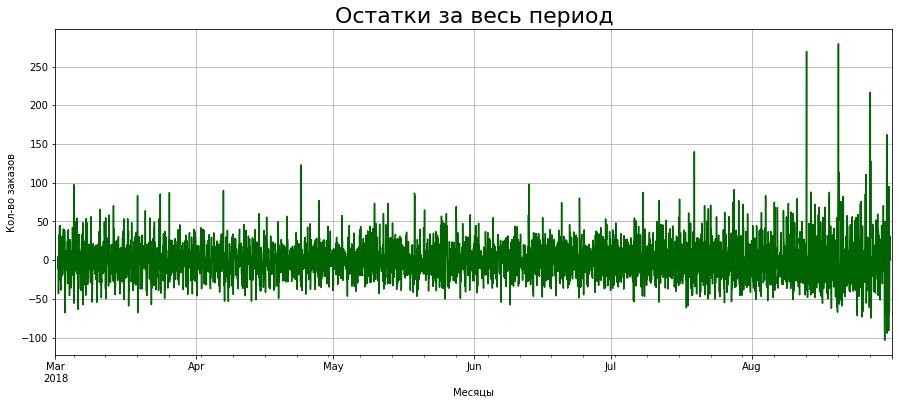

In [15]:
decomposed.resid.plot(figsize=(15,6), grid=True, color='darkgreen');
plt.title('Остатки за весь период', fontsize=22)
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

#decomposed_month.resid.plot(figsize=(15,6), grid=True, color='green');
#plt.title('Остатки за август')
#plt.xlabel('Месяцы')
#plt.ylabel('Кол-во заказов')
#plt.show()


#decomposed_week.resid.plot(figsize=(15,6), grid=True, color='limegreen');
#plt.title('Остатки по недели августа')
#plt.xlabel('дни')
#plt.ylabel('Кол-во заказов')
#plt.show()

#decomposed_day.resid.plot(figsize=(15,6), grid=True, color='lime');
#plt.title('Остатки по трем дням августа')
#plt.xlabel('часы')
#plt.ylabel('Кол-во заказов')
#plt.show()

**Вывод:** По анализам графиков можно сделать следующие выводы:
* График не стационарный тренд идет на явное возрастание
* Выявлена суточная сезонность, больше всего заков начинает поступать после 00:00, меньше всего заказов после 6:00 утра.
* Дни заказов отличаются больше всего заказывают такси по понедельникам.

## Обучение

Добавим к существующему датафрейму признаки:
* День недели
* День 
* час
Вычислим лаги и скользящее среднее

In [16]:
# Напишем для создания признаков
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    # Создадим цикл для вычисления отстающих значений
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    # Вычислим скользящее среднее    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [17]:
# Применим функцию к датафрейму
make_features(df, 24, 48)

# Разделим датафрейм на выборки
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

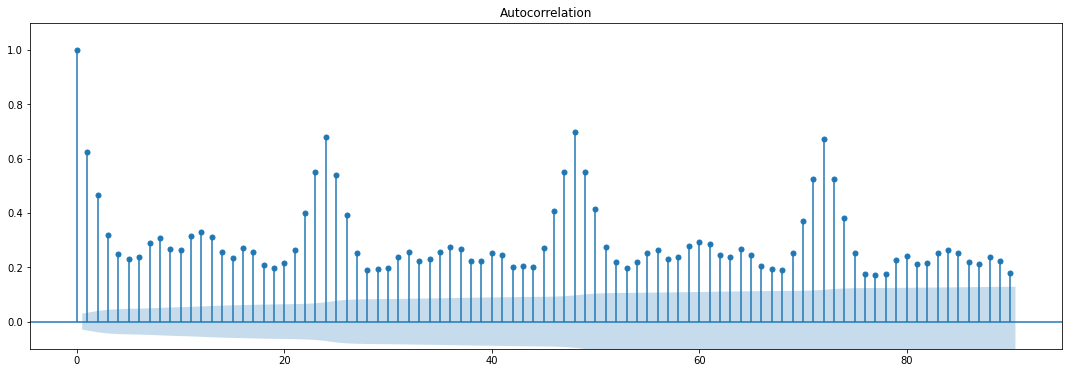

In [18]:
# Код ревьюера
from statsmodels.graphics import tsaplots

fig = tsaplots.plot_acf(df['num_orders'], lags= 90)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 



Подберем наилучшии параметры и обучим на тренировачных данных модели 

### Линейная регрессия LinearRegression

In [19]:
tscv = TimeSeriesSplit(n_splits=5)

In [20]:
%%time
# Применим метод разделение временных рядов
param_lr = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
lr_grid = GridSearchCV(LinearRegression(), param_grid = param_lr, scoring='neg_mean_squared_error', cv=tscv)
lr_grid.fit(features_train, target_train)

lr_best_params = lr_grid.best_params_
rmse_lr = (cross_val_score(lr_grid,
                           features_train, 
                           target_train, 
                           cv=tscv).mean() * -1) ** 0.5
print('Лучшие гиперпараметры: ', lr_best_params)
print('Среднее значение RMSE на тренировачной выбоке:', rmse_lr)

Лучшие гиперпараметры:  {'copy_X': True, 'fit_intercept': False, 'normalize': True}
Среднее значение RMSE на тренировачной выбоке: 27.421866347155543
CPU times: user 9.98 s, sys: 25.7 s, total: 35.7 s
Wall time: 35.9 s


### Модель RandomForestRegressor

In [21]:
%%time
param_rf = {
    'n_estimators' : range(50, 100, 10),
    'max_depth' : range(5, 15, 2),
    'verbose' : [0],
    'random_state' : [15]}
rf_grid = GridSearchCV(RandomForestRegressor(), param_grid = param_rf, cv=tscv)
rf_grid.fit(features_train, target_train)

rf_best_params = rf_grid.best_params_
rf_m = RandomForestRegressor(**rf_best_params)

rmse_rf = (cross_val_score(rf_m,
                            features_train, 
                            target_train, 
                            cv=tscv, 
                            scoring='neg_mean_squared_error').mean() * -1) ** 0.5

print('Лучшие гиперпараметры: ', rf_best_params)
print('Среднее значение RMSE:', rmse_rf)

Лучшие гиперпараметры:  {'max_depth': 13, 'n_estimators': 90, 'random_state': 15, 'verbose': 0}
Среднее значение RMSE: 24.741339881488766
CPU times: user 2min 40s, sys: 1.2 s, total: 2min 41s
Wall time: 2min 42s


### Модель CatBoostRegressor 

In [22]:
%%time
cbr_params = [{'learning_rate':[0.1, 0.2, 0.3],
                'random_state':[15],
                'verbose':[0]}]

cbr = GridSearchCV(CatBoostRegressor(), cbr_params)
cbr.fit(features_train, target_train)
cbr_best_params = cbr.best_params_

cbr_m = CatBoostRegressor(**cbr_best_params)

rmse_cbr = (cross_val_score(cbr_m,
                            features_train, 
                            target_train, 
                            cv=tscv, 
                            scoring='neg_mean_squared_error').mean() * -1) ** 0.5

print('Лучшие гиперпараметры: ', cbr_best_params)
print('Среднее значение RMSE:', rmse_cbr)

Лучшие гиперпараметры:  {'learning_rate': 0.1, 'random_state': 15, 'verbose': 0}
Среднее значение RMSE: 23.64425068978666
CPU times: user 2min, sys: 2.62 s, total: 2min 2s
Wall time: 2min 29s


Гиперпараметры найдены, модели обучены на тренировачной выборке, найдем RMSE на тестевой выборке.

## Тестирование

Применим параметры к нашим моделям с помощью  и найдем лучшую модель. 

### Модель LinearRegression на тестевой выборке

In [23]:
%%time

model = LinearRegression(**lr_best_params)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
final_rmse_lr = mean_squared_error(target_test, target_predict) ** 0.5
print('Значение RMSE линейной регрессии:', final_rmse_lr)

Значение RMSE линейной регрессии: 44.50284173342691
CPU times: user 39.8 ms, sys: 55.4 ms, total: 95.2 ms
Wall time: 81.5 ms


### Модель RandomForestRegressor на тестевой выборке

In [24]:
%%time

model = RandomForestRegressor(**rf_best_params) 
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
final_rmse_rf = mean_squared_error(target_test, target_predict) ** 0.5
print('Значение RMSE RandomForestRegressor:', final_rmse_rf)

Значение RMSE RandomForestRegressor: 42.60551173574654
CPU times: user 3.92 s, sys: 21.4 ms, total: 3.94 s
Wall time: 3.96 s


### Модель CatBoostRegressor на тестевой выборке

In [25]:
%%time

model = CatBoostRegressor(**cbr_best_params) 
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
final_rmse_cbr = mean_squared_error(target_test, target_predict) ** 0.5
print('Значение RMSE CatBoost регрессии:', final_rmse_cbr)

Значение RMSE CatBoost регрессии: 40.8796335303398
CPU times: user 6.35 s, sys: 110 ms, total: 6.46 s
Wall time: 7.49 s


In [26]:
index = ['LinearRegression',
         'RandomForestRegressor', 
         'CatBoostRegressor']
data = {'RMSE на тренировачной выборке': [rmse_lr,
                                          rmse_rf,
                                          rmse_cbr],
        'RMSE модели на тестовой выборке': [final_rmse_lr, 
                                            final_rmse_rf, 
                                            final_rmse_cbr]}
RMSE_models = pd.DataFrame(data=data, index=index)
RMSE_models

,RMSE на тренировачной выборке,RMSE модели на тестовой выборке
LinearRegression,27.421866,44.502842
RandomForestRegressor,24.741340,42.605512
CatBoostRegressor,23.644251,40.879634


**Вывод:** Лучшее значение RMSE показала модель CatBoostRegressor, также хорошие значения показала модель дерево решений. Линейная регрессия на тестевой выборке показала худший результат. При этом все модели пока Значение метрики RMSE на тестовой выборке должно быть не больше 48. 

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [X]  Весь код выполняется без ошибок
- [X]  Ячейки с кодом расположены в порядке исполнения
- [X]  Данные загружены и подготовлены
- [X]  Данные проанализированы
- [X]  Модель обучена, гиперпараметры подобраны
- [X]  Качество моделей проверено, выводы сделаны
- [X]  Значение *RMSE* на тестовой выборке не больше 48